In [1]:
import pandas as pd  # Library untuk manipulasi data dalam bentuk DataFrame
import numpy as np  # Library untuk komputasi numerik, operasi array, dan matriks
import matplotlib.pyplot as plt  # Library untuk membuat visualisasi grafik
import seaborn as sns  # Library untuk visualisasi data statistik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV  # Fungsi untuk membagi data dan mencari hyperparameter terbaik
from sklearn.linear_model import LogisticRegression  # Model klasifikasi berbasis regresi logistik
from sklearn.neighbors import KNeighborsClassifier  # Model klasifikasi k-Nearest Neighbors (KNN)
from xgboost import XGBClassifier  # Model XGBoost untuk klasifikasi
from yellowbrick.classifier import ROCAUC  # Visualisasi ROC curve dari library Yellowbrick
from imblearn.over_sampling import SMOTE  # Teknik untuk menangani data yang tidak seimbang dengan oversampling kelas minoritas
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score  # Evaluasi model seperti ROC curve, AUC, precision, recall, dan akurasi
import plotly.express as px
from sklearn.metrics import confusion_matrix
import kagglehub
import joblib
import os
from xgboost import plot_importance

In [2]:
# Download latest version
path = kagglehub.dataset_download("wilmanufatimah22/near-earth-object-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/near-earth-object-dataset


In [3]:
# Path ke direktori dataset
dataset_path = '/kaggle/input/near-earth-object-dataset'

# List file dalam direktori
print("File dalam direktori:")
print(os.listdir(dataset_path))

File dalam direktori:
['data_preprocessed.csv']


In [4]:
# Path ke direktori dataset
dataset_path = '/kaggle/input/near-earth-object-dataset'

# Nama file dataset
file_name = 'data_preprocessed.csv'

# Membaca file CSV
df = pd.read_csv(f'{dataset_path}/{file_name}')

# Tampilkan beberapa baris pertama dari dataset
print("Dataset Preview:")
df.head()

Dataset Preview:


,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous,moid
0,-1.404852,1.458702,1.572803,0.816947,0.813685,0,0.105261
1,-1.628087,2.083379,2.152058,2.280802,0.701647,1,0.030238
2,-0.599112,0.075635,0.147109,-0.979324,1.247151,0,0.059966
3,-0.885132,0.436994,0.542769,1.090705,-0.513372,0,0.154436
4,-0.163105,-0.288098,-0.272000,0.215038,1.051623,0,0.034305


In [5]:
# Memisahkan kolom fitur dan target
X = df.drop(columns=['is_hazardous']) # Fitur
y = df['is_hazardous'] # Target

In [6]:
# Menangani data yang tidak seimbang pada kolom target (is hazardous)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f'Original y distribution: {y.value_counts()}')
print(f'Resampled y distribution: {pd.Series(y_resampled).value_counts()}')

Original y distribution: is_hazardous
0    267017
1     35632
Name: count, dtype: int64
Resampled y distribution: is_hazardous
0    267017
1    267017
Name: count, dtype: int64


In [7]:
# Membagi data menjadi data training dan data test dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Melihat jumlah data pada training set dan test set
print(f'Jumlah data pada training set (X_train): {len(X_train)}')
print(f'Jumlah data pada test set (X_test): {len(X_test)}')
print(f'Jumlah label pada training set (y_train): {len(y_train)}')
print(f'Jumlah label pada test set (y_test): {len(y_test)}')

Jumlah data pada training set (X_train): 427227
Jumlah data pada test set (X_test): 106807
Jumlah label pada training set (y_train): 427227
Jumlah label pada test set (y_test): 106807


In [8]:
# Definisikan model Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Definisikan parameter grid untuk pencarian
param_grid_logreg = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
}

# Grid Search
grid_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid_logreg, 
                           cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_logreg.fit(X_train, y_train)

# Model terbaik
best_logreg = grid_logreg.best_estimator_
print("Best Logistic Regression Parameters:", grid_logreg.best_params_)

# Melatih model terbaik dan melakukan prediksi
best_logreg.fit(X_train, y_train)
y_pred_best_logreg = best_logreg.predict(X_test)

# Menampilkan performa model terbaik
print("Best Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred_best_logreg))

# Menghitung akurasi dan ROC AUC
accuracy_best_logreg = accuracy_score(y_test, y_pred_best_logreg)
roc_auc_best_logreg = roc_auc_score(y_test, best_logreg.predict_proba(X_test)[:, 1])

# Menampilkan hasil akurasi dan ROC AUC
print(f"Accuracy: {accuracy_best_logreg}")
print(f"ROC AUC: {roc_auc_best_logreg}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

Best Logistic Regression Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     53361
           1       0.96      0.99      0.97     53446

    accuracy                           0.97    106807
   macro avg       0.97      0.97      0.97    106807
weighted avg       0.97      0.97      0.97    106807

Accuracy: 0.9732695422584662
ROC AUC: 0.9960472844456726


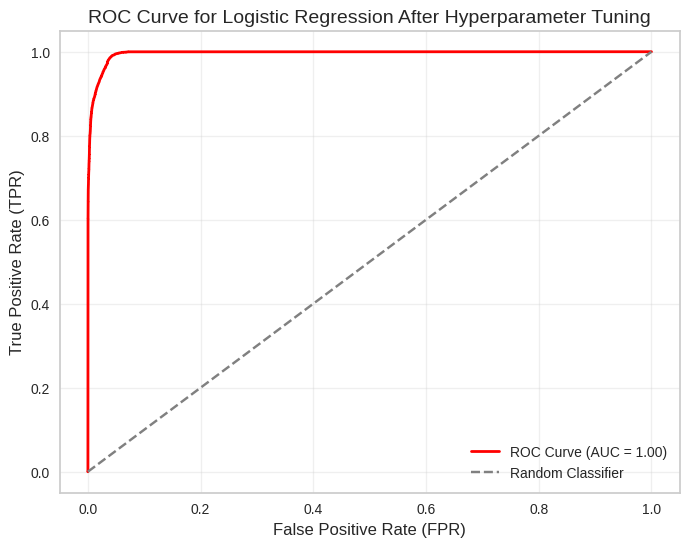

In [9]:
# Hitung probabilitas prediksi untuk kelas positif
y_prob_best_logreg = best_logreg.predict_proba(X_test)[:, 1]

# Hitung nilai False Positive Rate (FPR), True Positive Rate (TPR), dan thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best_logreg)

# Hitung nilai AUC
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='Red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Logistic Regression After Hyperparameter Tuning', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

Confusion Matrix:
[[51236  2125]
 [  730 52716]]


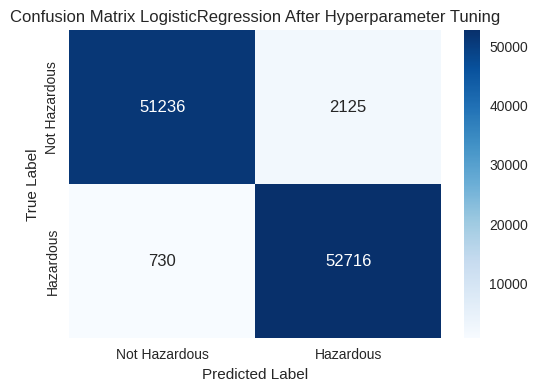

In [10]:
# Confusion Matrix
conf_matrix_LG = confusion_matrix(y_test, y_pred_best_logreg)
print("Confusion Matrix:")
print(conf_matrix_LG)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_LG, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hazardous', 'Hazardous'], yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix LogisticRegression After Hyperparameter Tuning')
plt.show()

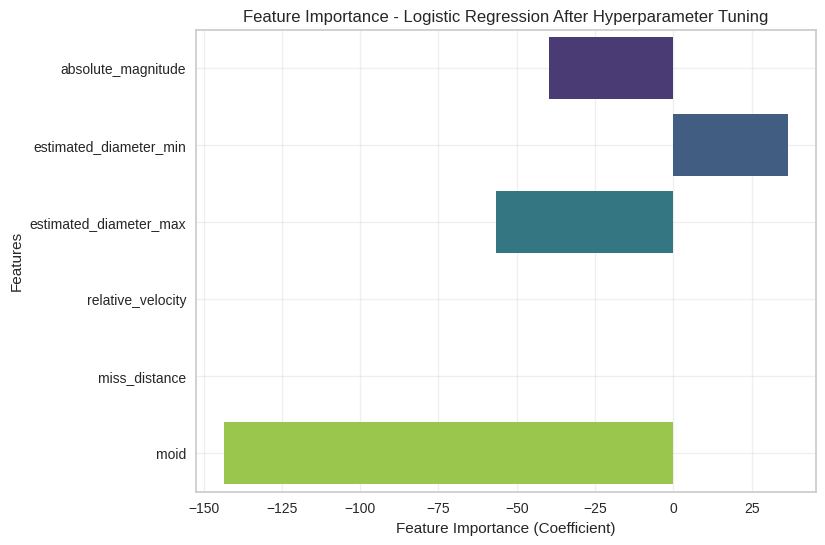

In [11]:
# Menampilkan koefisien fitur
feature_importance = best_logreg.coef_[0]  # Koefisien dari model terbaik
features = X_train.columns  # Nama fitur

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=features, palette='viridis')
plt.xlabel('Feature Importance (Coefficient)')
plt.ylabel('Features')
plt.title('Feature Importance - Logistic Regression After Hyperparameter Tuning')
plt.grid(alpha=0.3)
plt.show()

In [12]:
# Menyimpan model ke direktori /kaggle/working/
# Menyimpan model Logistic Regression terbaik
joblib.dump(best_logreg, '/kaggle/working/best_logreg_model.pkl')

# Diunduh di tab Output

['/kaggle/working/best_logreg_model.pkl']

In [13]:
# Definisikan model KNN
knn = KNeighborsClassifier()

# Definisikan parameter grid untuk pencarian
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Grid Search
grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, 
                        cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_knn.fit(X_train, y_train)

# Model terbaik
best_knn = grid_knn.best_estimator_
print("Best KNN Parameters:", grid_knn.best_params_)

# Melatih model terbaik dan melakukan prediksi
best_knn.fit(X_train, y_train)
y_pred_best_knn = best_knn.predict(X_test)

# Menampilkan performa model terbaik
print("Best KNN Model Performance:")
print(classification_report(y_test, y_pred_best_knn))

# Menghitung akurasi dan ROC AUC
accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
roc_auc_best_knn = roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1])

# Menampilkan hasil akurasi dan ROC AUC
print(f"Accuracy: {accuracy_best_knn}")
print(f"ROC AUC: {roc_auc_best_knn}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best KNN Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     53361
           1       0.93      1.00      0.97     53446

    accuracy                           0.96    106807
   macro avg       0.97      0.96      0.96    106807
weighted avg       0.97      0.96      0.96    106807

Accuracy: 0.9644030821949873
ROC AUC: 0.9939289288932648


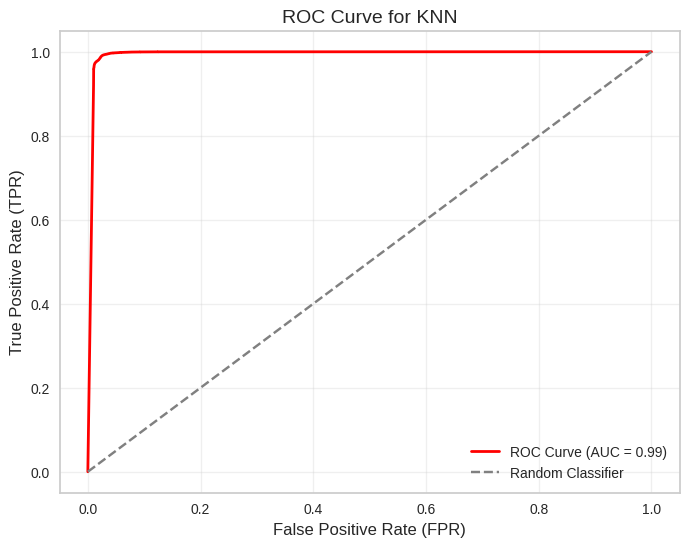

In [14]:
# Hitung probabilitas prediksi untuk kelas positif
y_prob_best_knn = best_knn.predict_proba(X_test)[:, 1]

# Hitung nilai False Positive Rate (FPR), True Positive Rate (TPR), dan thresholds
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_prob_best_knn)

# Hitung nilai AUC untuk KNN
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC Curve untuk KNN
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='Red', lw=2, label=f'ROC Curve (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for KNN', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

Confusion Matrix:
[[49623  3738]
 [   64 53382]]


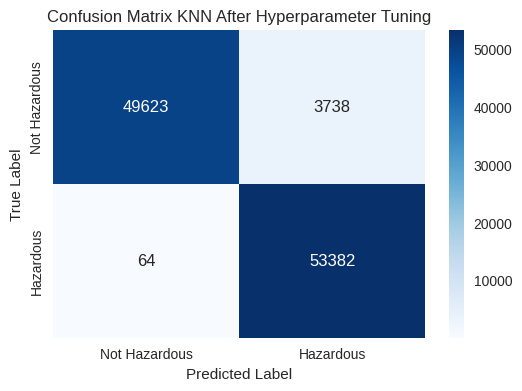

In [15]:
# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_best_knn)
print("Confusion Matrix:")
print(conf_matrix_knn)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hazardous', 'Hazardous'], yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix KNN After Hyperparameter Tuning')
plt.show()

In [16]:
# Menyimpan model ke direktori /kaggle/working/
# Menyimpan model KNN terbaik
joblib.dump(best_knn, '/kaggle/working/best_knn_model.pkl')

# Diunduh di tab Output

['/kaggle/working/best_knn_model.pkl']

In [17]:
# Definisikan model XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Definisikan parameter grid untuk pencarian
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

# Grid Search
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, 
                        cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

# Model terbaik
best_xgb = grid_xgb.best_estimator_
print("Best XGBoost Parameters:", grid_xgb.best_params_)

# Melatih model terbaik dan melakukan prediksi
best_xgb.fit(X_train, y_train)
y_pred_best_xgb = best_xgb.predict(X_test)

# Menampilkan performa model terbaik
print("Best XGBoost Model Performance:")
print(classification_report(y_test, y_pred_best_xgb))

# Menghitung akurasi dan ROC AUC
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
roc_auc_best_xgb = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])

# Menampilkan hasil akurasi dan ROC AUC
print(f"Accuracy: {accuracy_best_xgb}")
print(f"ROC AUC: {roc_auc_best_xgb}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best XGBoost Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best XGBoost Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53361
           1       1.00      1.00      1.00     53446

    accuracy                           1.00    106807
   macro avg       1.00      1.00      1.00    106807
weighted avg       1.00      1.00      1.00    106807

Accuracy: 0.9992041720111978
ROC AUC: 0.9999962088857739


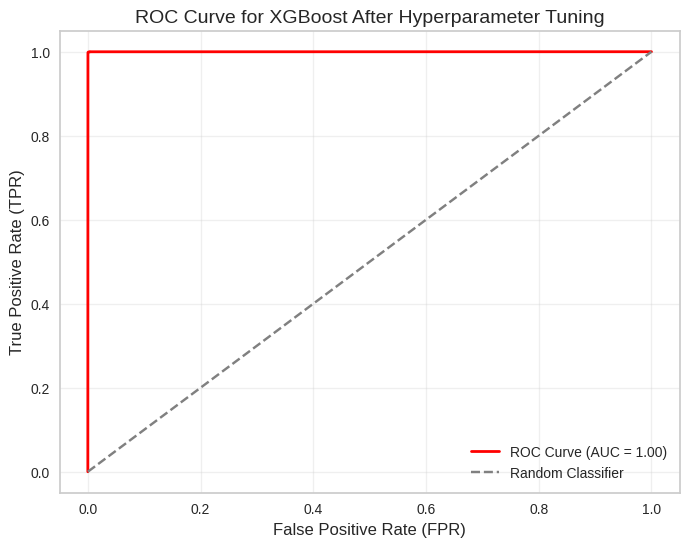

In [18]:
# Hitung probabilitas prediksi untuk kelas positif
y_prob_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Hitung nilai False Positive Rate (FPR), True Positive Rate (TPR), dan thresholds
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_best_xgb)

# Hitung nilai AUC untuk XGBoost
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curve untuk XGBoost
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='Red', lw=2, label=f'ROC Curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for XGBoost After Hyperparameter Tuning', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

Confusion Matrix:
[[53330    31]
 [   54 53392]]


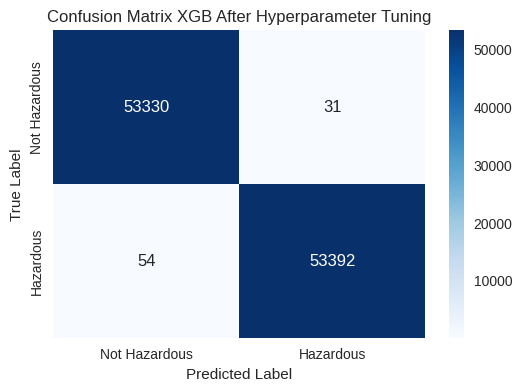

In [19]:
# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_best_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hazardous', 'Hazardous'], yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix XGB After Hyperparameter Tuning')
plt.show()

<Figure size 1000x800 with 0 Axes>

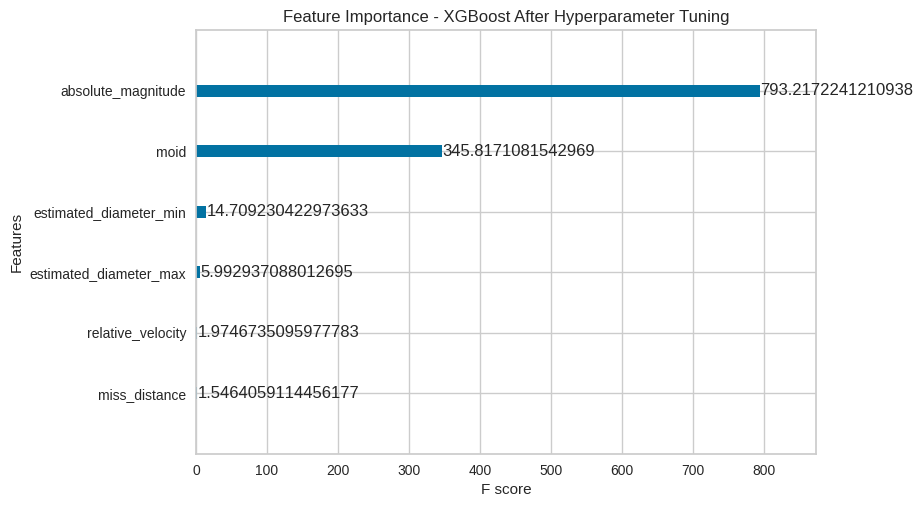

In [20]:
# Menampilkan feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, importance_type='gain', title='Feature Importance - XGBoost After Hyperparameter Tuning')
plt.show()

In [21]:
# Menyimpan model ke direktori /kaggle/working/
# Menyimpan model xgb terbaik
joblib.dump(best_xgb, '/kaggle/working/best_xgb_model.pkl')

# Diunduh di tab Output

['/kaggle/working/best_xgb_model.pkl']